In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix 
from sklearn import svm
import seaborn as sns

In [16]:
seed = 42

## improve speed by limiting max columns shown at once
pd.set_option('display.max_columns', 50)

### Merge the match data from 2000-2020

In [17]:
frames = []

# Add games from years 2000-2020
for year in range(2000, 2021):
    frames.append(pd.read_csv("./data/matches_{}.csv".format(year)))

df = pd.concat(frames)

### Clean up the data

In [18]:
## irrelevant columns
irr_cols = []
player_cols = ["ace", "df", "svpt", "1stIn", "1stWon", "2ndWon", "SvGms", "bpSaved", "bpFaced"]
general_cols = ["winner_name", "tourney_name", "loser_name", "winner_ioc", "loser_ioc", "minutes", "score", "draw_size", "round", "loser_seed", "loser_entry", "loser_rank_points", "winner_rank_points", "winner_seed", "winner_entry", "match_num", "tourney_id", "tourney_level", "best_of"]
## add winner/loser cols
for el in player_cols:
    irr_cols.append("w_{}".format(el))
    irr_cols.append("l_{}".format(el))

## add the general cols
irr_cols.extend(general_cols)

## drop irrelevant cols
df.drop(columns=irr_cols, inplace=True)

## calculate mean height of the players and replace null values with it
mean_ht = (df["winner_ht"].mean() + df["loser_ht"].mean()) / 2
df.loc[df["winner_ht"].isnull(), "winner_ht"] = mean_ht
df.loc[df["loser_ht"].isnull(), "loser_ht"] = mean_ht

## drop empty values
df.dropna(axis=0, inplace=True)

### Convert numerical values to floats

In [19]:
numeric_cols = ["winner_rank", "loser_rank", "winner_age", "loser_age", "winner_ht", "loser_ht"]
df[numeric_cols] = df[numeric_cols].astype(float)

### Adjust the dataset for performing predictions

In [22]:
## replace winner/loser with player1 & 2
for (colName, colData) in df.iteritems():
    if "winner" in colName:
        endingVal = colName.split("_")[1]
        df.rename(columns={colName: "player1_{}".format(endingVal)}, inplace=True)
    elif "loser" in colName:
        endingVal = colName.split("_")[1]
        df.rename(columns={colName: "player2_{}".format(endingVal)}, inplace=True)


## swap the labels for half of the values

first_half, second_half = df[:int(len(df) / 2)], df[int(len(df) / 2):]
first_half.insert(loc=0, column="label", value=1)

## swap columns
scols = list(second_half.columns)

np.warnings.filterwarnings('ignore')

## swap the columns for the second half
for attr in ["id", "hand", "ht", "age", "rank"]:
    scols[scols.index("player1_{}".format(attr))], scols[scols.index("player2_{}".format(attr))] = scols[scols.index("player2_{}".format(attr))], scols[scols.index("player1_{}".format(attr))]
    # second_half.insert(loc=0, column="label", value=0)
    second_half["label"] = 0

halves = []

df = pd.concat([first_half, second_half])


### Visualize data

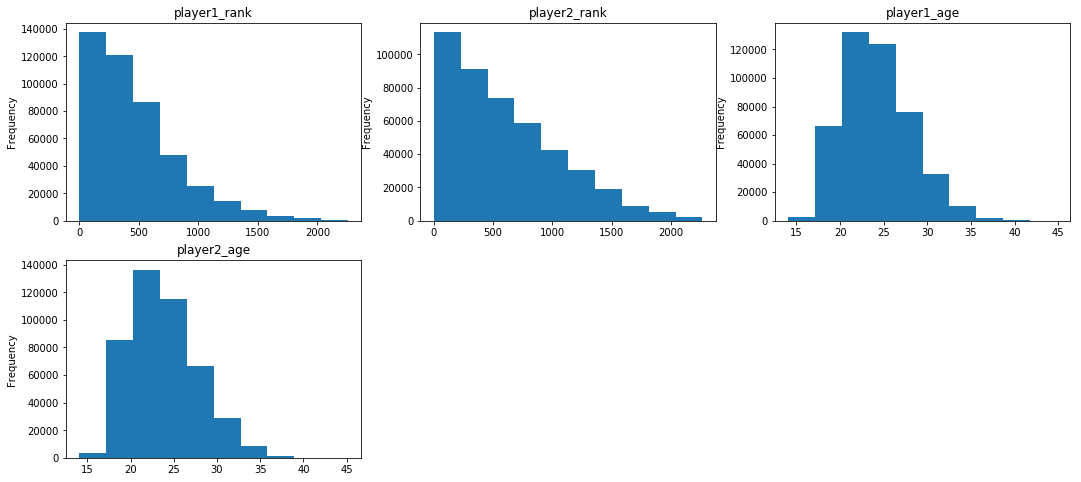

In [23]:
cols = ["player1_rank", "player2_rank", "player1_age", "player2_age"]

plt.figure(1, figsize=(18, 8))

for i in range(len(cols)):
    plt.subplot(2, 3, i + 1)
    df[cols[i]].plot(kind="hist", title=cols[i])

plt.show()

### Prepare data for ML models

In [24]:
## convert categorical values (player hand, surface) to numbers
le = LabelEncoder()
df["surface"] = le.fit_transform(df["surface"])
df["player1_hand"] = le.fit_transform(df["player1_hand"])
df["player2_hand"] = le.fit_transform(df["player2_hand"])

## features that will be used in the model
features = ["player1_ht", "player2_ht", "player1_age", "player2_age", "player1_rank", "player2_rank", "surface", "player1_hand", "player2_hand"]
X = df[features]
y = df["label"]

kf = KFold(n_splits=3, shuffle=True, random_state=seed)

### Logistic Regression

In [51]:
clf_1 = LogisticRegression()

train_accs_lr, val_accs_lr, train_errs_lr, val_errs_lr, precisions_lr = [], [], [], [], []
# val_train_accs_lr = []

for train_indices, val_indices in kf.split(X):
    X_train, X_val, y_train, y_val = X.iloc[train_indices], X.iloc[val_indices], y.iloc[train_indices], y.iloc[val_indices]
    
    ## training the model
    # logistic
    clf_1.fit(X_train, y_train)
    y_pred_train_1 = clf_1.predict(X_train)
    acc_train_1 = clf_1.score(X_train, y_train)
    accuracy_1 = clf_1.score(X, y)
    
    # decision tree
    # clf_dectree = DecisionTreeClassifier()
    # clf_dectree = clf_dectree.fit(X_train, y_train)
    # y_pred = clf_dectree.predict(X_train)


    ## validation
    y_pred_val_1 = clf_1.predict(X_val)
    acc_val_1 = clf_1.score(X_val, y_val)

    ## confusion matrix
    conf_mat = confusion_matrix(y, np.concatenate([y_pred_train_1, y_pred_val_1]))

    ## calculate the precision by dividing TP by (TP + FP)
    ## it denotes the proportion of true positives in total positives
    true_pos = conf_mat[1][1]
    false_pos = conf_mat[0][1]
    precision = true_pos * 1.0 / (true_pos + false_pos)


    ## errors
    err_train = log_loss(y_train, y_pred_train_1)
    err_val = log_loss(y_val, y_pred_val_1)

    # add results to corresponding containers
    train_accs_lr.append(acc_train_1)
    val_accs_lr.append(acc_val_1)
    train_errs_lr.append(err_train)
    val_errs_lr.append(err_val)
    print(conf_mat)
    precisions_lr.append(precision)

print("training accuracy: {}".format(sum(train_accs_lr) * 1.0 / len(train_accs_lr)))
print("training error: {}".format(sum(train_errs_lr) * 1.0 / len(train_errs_lr)))
print("validation accuracy: {}".format(sum(val_accs_lr) * 1.0 / len(val_accs_lr)))
print("validation error: {}".format(sum(val_errs_lr) * 1.0 / len(val_errs_lr)))
print("precision: {}".format(sum(precisions_lr) * 1.0 / len(precisions_lr)))


[[117858 105308]
 [ 96162 127003]]
[[117934 105232]
 [ 95151 128014]]
[[118393 104773]
 [ 96171 126994]]
training accuracy: 0.606928490291
training error: 13.5763744637
validation accuracy: 0.606818706296
validation error: 13.5801662407
precision: 0.0


### Support vector macines

In [42]:
## diminish the array for SVM (depending on GPU-capacity, choose the diminisher value)
diminisher = 0.01
df_svm = df.sample(int(len(df) * diminisher))

X_svm, y_svm = df_svm[features], df_svm["label"]

X_svm_train, X_svm_val, y_svm_train, y_svm_val = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)

train_accs = []
val_accs = []

for i in range(5):
    clf_2 = svm.SVC()
    clf_2.fit(X_svm_train, y_svm_train)
    y_pred_train_2 = clf_2.predict(X_svm_train)
    acc_train_2 = clf_2.score(X_svm_val, y_svm_val)
    y_pred_val_2 = clf_2.predict(X_svm_val)
    acc_val_2 = clf_2.score(X_svm_val, y_svm_val)
    
    train_accs.append(acc_train_2)
    val_accs.append(acc_val_2)


print("training accuracy: {}".format(sum(train_accs) * 1.0 / len(train_accs)))
print("validation accuracy: {}".format(sum(val_accs) * 1.0 / len(val_accs)))


training accuracy: 0.521836506159
validation accuracy: 0.521836506159
